# Pommerman Demo.

This notebook demonstrates how to train Pommerman agents. Please let us know at support@pommerman.com if you run into any issues.

In [1]:
import os
import sys
import numpy as np

from pommerman.agents import SimpleAgent, RandomAgent, PlayerAgent, BaseAgent
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility

# Make sure you have tensorforce installed: pip install tensorforce
from tensorforce.agents import PPOAgent
from tensorforce.execution import Runner
from tensorforce.contrib.openai_gym import OpenAIGym

# Random agents

The following codes instantiates the environment with four random agents who take actions until the game is finished. (This will be a quick game.)

In [4]:
# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

In [5]:
# Add four random agents
agents = {}
for agent_id in range(4):
    agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))
env.set_agents(list(agents.values()))
env.set_init_game_state(None)

In [6]:
# Seed and reset the environment
env.seed(0)
obs = env.reset()

# Run the random agents until we're done
done = False
while not done:
    env.render()
    actions = env.act(obs)
    obs, reward, done, info = env.step(actions)
env.render(close=True)
env.close()

print(info)

{'result': <Result.Win: 0>, 'winners': [3]}


# Human Agents

The following code runs the environment with 3 random agents and one agent with human input (use the arrow keys on your keyboard). This can also be called on the command line with:

`python run_battle.py --agents=player::arrows,random::null,random::null,random::null --config=PommeFFACompetition-v0`

You can also run this with SimpleAgents by executing:

`python run_battle.py --agents=player::arrows,test::agents.SimpleAgent,test::agents.SimpleAgent,test::agents.SimpleAgent --config=PommeFFACompetition-v0`

In [5]:
# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

# Add 3 random agents
agents = {}
for agent_id in range(3):
    agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))

# Add human agent
agents[3] = PlayerAgent(config["agent"](agent_id, config["game_type"]), "arrows")

env.set_agents(list(agents.values()))
env.set_init_game_state(None)

In [6]:
# Seed and reset the environment
env.seed(0)
obs = env.reset()

# Run the agents until we're done
done = False
while not done:
    env.render()
    actions = env.act(obs)
    obs, reward, done, info = env.step(actions)
env.render(close=True)
env.close()

# Print the result
print(info)

{'result': <Result.Win: 0>, 'winners': [1]}


# Training an Agent

The following code uses Tensorforce to train a PPO agent. This is in the train_with_tensorforce.py module as well.

In [7]:
# Make sure you have tensorforce installed: pip install tensorforce
from tensorforce.agents import PPOAgent
from tensorforce.execution import Runner
from tensorforce.contrib.openai_gym import OpenAIGym

In [14]:
def make_np_float(feature):
    return np.array(feature).astype(np.float32)

def featurize(obs):
    board = obs["board"].reshape(-1).astype(np.float32)
    bomb_blast_strength = obs["bomb_blast_strength"].reshape(-1).astype(np.float32)
    bomb_life = obs["bomb_life"].reshape(-1).astype(np.float32)
    position = make_np_float(obs["position"])
    ammo = make_np_float([obs["ammo"]])
    blast_strength = make_np_float([obs["blast_strength"]])
    can_kick = make_np_float([obs["can_kick"]])

    teammate = obs["teammate"]
    if teammate is not None:
        teammate = teammate.value
    else:
        teammate = -1
    teammate = make_np_float([teammate])

    enemies = obs["enemies"]
    enemies = [e.value for e in enemies]
    if len(enemies) < 3:
        enemies = enemies + [-1]*(3 - len(enemies))
    enemies = make_np_float(enemies)

    return np.concatenate((board, bomb_blast_strength, bomb_life, position, ammo, blast_strength, can_kick, teammate, enemies))

class TensorforceAgent(BaseAgent):
    def act(self, obs, action_space):
        pass

In [9]:
config

{'agent': pommerman.characters.Bomber,
 'env_kwargs': {'game_type': <GameType.FFA: 1>,
  'board_size': 11,
  'num_rigid': 36,
  'num_wood': 36,
  'num_items': 20,
  'max_steps': 800,
  'render_fps': 1000,
  'env': 'pommerman.envs.v0:Pomme'},
 'env_id': 'PommeFFAFast-v0',
 'env_entry_point': 'pommerman.envs.v0:Pomme',
 'game_type': <GameType.FFA: 1>,
 'env': pommerman.envs.v0.Pomme}

In [43]:
# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])
env.seed(0)

# Create a Proximal Policy Optimization agent
agent = PPOAgent(
    states=dict(type='float', shape=env.observation_space.shape),
    actions=dict(type='int', num_actions=env.action_space.n),
    network=[
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ],
    batching_capacity=1000,
    step_optimizer=dict(
        type='adam',
        learning_rate=1e-4
    ),

    # PGModel
    baseline_mode='network',
    baseline=dict(type='custom', network=[
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ]),
    baseline_optimizer=dict(
        type='adam',
        learning_rate=1e-4
    ),
)

# Add 3 random agents
agents = []
for agent_id in range(3):
    agents.append(SimpleAgent(config["agent"](agent_id, config["game_type"])))

# Add TensorforceAgent
agent_id += 1
agents.append(TensorforceAgent(config["agent"](agent_id, config["game_type"])))
env.set_agents(agents)
env.set_training_agent(agents[-1].agent_id)
env.set_init_game_state(None)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [12]:
env.reset()
len(env.get_observations())
for ob in env.get_observations():
    print('\n\n')
    print(ob)
    print('\n\n')




{'alive': [10, 11, 12, 13], 'board': array([[ 0,  1,  0,  0,  1,  0,  1,  2,  1,  1,  0],
       [ 1, 10,  0,  0,  2,  2,  2,  0,  0, 13,  2],
       [ 0,  0,  0,  2,  0,  2,  1,  2,  1,  0,  1],
       [ 0,  0,  2,  0,  2,  1,  1,  1,  1,  0,  0],
       [ 1,  2,  0,  2,  0,  0,  0,  1,  1,  2,  2],
       [ 0,  2,  2,  1,  0,  0,  2,  1,  0,  2,  2],
       [ 1,  2,  1,  1,  0,  2,  0,  2,  0,  2,  2],
       [ 2,  0,  2,  1,  1,  1,  2,  0,  1,  0,  1],
       [ 1,  0,  1,  1,  1,  0,  0,  1,  0,  0,  2],
       [ 1, 11,  0,  0,  2,  2,  2,  0,  0, 12,  1],
       [ 0,  2,  1,  0,  2,  2,  2,  1,  2,  1,  0]], dtype=uint8), 'bomb_blast_strength': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0

In [13]:
class WrappedEnv(OpenAIGym):    
    def __init__(self, gym, visualize=False):
        self.gym = gym
        self.visualize = visualize
    
    def execute(self, action):
        if self.visualize:
            self.gym.render()

        actions = self.unflatten_action(action=action)

        obs = self.gym.get_observations()
        all_actions = self.gym.act(obs)
        all_actions.insert(self.gym.training_agent, actions)
        state, reward, terminal, _ = self.gym.step(all_actions)
        agent_state = featurize(state[self.gym.training_agent])
        agent_reward = reward[self.gym.training_agent]
        return agent_state, terminal, agent_reward
    
    def reset(self):
        obs = self.gym.reset()
        agent_obs = featurize(obs[3])
        return agent_obs

In [44]:
# Instantiate and run the environment for 5 episodes.

# Callback function printing episode statistics
def episode_finished(r):
    if r.episode % 100 == 0:
        print("Finished episode {ep} after {ts} timesteps (reward: {reward})".format(ep=r.episode, ts=r.episode_timestep,
                                                                                     reward=r.episode_rewards[-1]))
    return True


wrapped_env = WrappedEnv(env, visualize=False)
runner = Runner(agent=agent, environment=wrapped_env)
runner.run(episodes=120000, max_episode_timesteps=2000, episode_finished=episode_finished)
# print("Stats: ", runner.episode_rewards, runner.episode_timesteps, runner.episode_times)

agent.save_model('/Users/voiceup/Git/cs221-pommerman/playground/notebooks/saved_ckpts/')

try:
    runner.close()
except AttributeError as e:
    pass

Finished episode 100 after 24 timesteps (reward: -1)
Finished episode 200 after 87 timesteps (reward: -1)
Finished episode 300 after 58 timesteps (reward: -1)
Finished episode 400 after 111 timesteps (reward: -1)
Finished episode 500 after 158 timesteps (reward: -1)
Finished episode 600 after 269 timesteps (reward: -1)
Finished episode 700 after 69 timesteps (reward: -1)
Finished episode 800 after 101 timesteps (reward: -1)
Finished episode 900 after 360 timesteps (reward: -1)
Finished episode 1000 after 416 timesteps (reward: -1)
Finished episode 1100 after 126 timesteps (reward: -1)
Finished episode 1200 after 124 timesteps (reward: 1)
Finished episode 1300 after 296 timesteps (reward: -1)
Finished episode 1400 after 165 timesteps (reward: -1)
Finished episode 1500 after 135 timesteps (reward: -1)
Finished episode 1600 after 254 timesteps (reward: -1)
Finished episode 1700 after 132 timesteps (reward: -1)
Finished episode 1800 after 240 timesteps (reward: -1)
Finished episode 1900 af

Finished episode 15000 after 118 timesteps (reward: -1)
Finished episode 15100 after 127 timesteps (reward: -1)
Finished episode 15200 after 142 timesteps (reward: -1)
Finished episode 15300 after 333 timesteps (reward: -1)
Finished episode 15400 after 242 timesteps (reward: -1)
Finished episode 15500 after 84 timesteps (reward: -1)
Finished episode 15600 after 113 timesteps (reward: -1)
Finished episode 15700 after 129 timesteps (reward: -1)
Finished episode 15800 after 140 timesteps (reward: -1)
Finished episode 15900 after 132 timesteps (reward: -1)
Finished episode 16000 after 114 timesteps (reward: -1)
Finished episode 16100 after 175 timesteps (reward: -1)
Finished episode 16200 after 97 timesteps (reward: -1)
Finished episode 16300 after 144 timesteps (reward: -1)
Finished episode 16400 after 801 timesteps (reward: -1)
Finished episode 16500 after 334 timesteps (reward: 1)
Finished episode 16600 after 151 timesteps (reward: -1)
Finished episode 16700 after 110 timesteps (reward:

Finished episode 29700 after 115 timesteps (reward: -1)
Finished episode 29800 after 201 timesteps (reward: -1)
Finished episode 29900 after 192 timesteps (reward: -1)
Finished episode 30000 after 231 timesteps (reward: -1)
Finished episode 30100 after 122 timesteps (reward: -1)
Finished episode 30200 after 147 timesteps (reward: -1)
Finished episode 30300 after 142 timesteps (reward: -1)
Finished episode 30400 after 168 timesteps (reward: -1)
Finished episode 30500 after 187 timesteps (reward: -1)
Finished episode 30600 after 135 timesteps (reward: -1)
Finished episode 30700 after 173 timesteps (reward: -1)
Finished episode 30800 after 88 timesteps (reward: -1)
Finished episode 30900 after 243 timesteps (reward: -1)
Finished episode 31000 after 152 timesteps (reward: -1)
Finished episode 31100 after 116 timesteps (reward: 1)
Finished episode 31200 after 86 timesteps (reward: -1)
Finished episode 31300 after 168 timesteps (reward: -1)
Finished episode 31400 after 296 timesteps (reward:

Finished episode 44400 after 141 timesteps (reward: -1)
Finished episode 44500 after 98 timesteps (reward: -1)
Finished episode 44600 after 133 timesteps (reward: -1)
Finished episode 44700 after 166 timesteps (reward: -1)
Finished episode 44800 after 102 timesteps (reward: -1)
Finished episode 44900 after 91 timesteps (reward: -1)
Finished episode 45000 after 91 timesteps (reward: -1)
Finished episode 45100 after 123 timesteps (reward: -1)
Finished episode 45200 after 236 timesteps (reward: -1)
Finished episode 45300 after 322 timesteps (reward: -1)
Finished episode 45400 after 170 timesteps (reward: -1)
Finished episode 45500 after 416 timesteps (reward: -1)
Finished episode 45600 after 467 timesteps (reward: -1)
Finished episode 45700 after 193 timesteps (reward: -1)
Finished episode 45800 after 104 timesteps (reward: -1)
Finished episode 45900 after 85 timesteps (reward: -1)
Finished episode 46000 after 112 timesteps (reward: 1)
Finished episode 46100 after 121 timesteps (reward: -

Finished episode 59100 after 435 timesteps (reward: -1)
Finished episode 59200 after 172 timesteps (reward: 1)
Finished episode 59300 after 120 timesteps (reward: -1)
Finished episode 59400 after 148 timesteps (reward: -1)
Finished episode 59500 after 105 timesteps (reward: -1)
Finished episode 59600 after 150 timesteps (reward: -1)
Finished episode 59700 after 190 timesteps (reward: -1)
Finished episode 59800 after 344 timesteps (reward: -1)
Finished episode 59900 after 141 timesteps (reward: -1)
Finished episode 60000 after 185 timesteps (reward: -1)
Finished episode 60100 after 452 timesteps (reward: -1)
Finished episode 60200 after 364 timesteps (reward: -1)
Finished episode 60300 after 319 timesteps (reward: -1)
Finished episode 60400 after 112 timesteps (reward: -1)
Finished episode 60500 after 252 timesteps (reward: -1)
Finished episode 60600 after 135 timesteps (reward: -1)
Finished episode 60700 after 119 timesteps (reward: -1)
Finished episode 60800 after 73 timesteps (reward

Finished episode 73800 after 101 timesteps (reward: -1)
Finished episode 73900 after 90 timesteps (reward: -1)
Finished episode 74000 after 108 timesteps (reward: -1)
Finished episode 74100 after 160 timesteps (reward: -1)
Finished episode 74200 after 299 timesteps (reward: 1)
Finished episode 74300 after 81 timesteps (reward: -1)
Finished episode 74400 after 79 timesteps (reward: -1)
Finished episode 74500 after 226 timesteps (reward: -1)
Finished episode 74600 after 220 timesteps (reward: -1)
Finished episode 74700 after 177 timesteps (reward: -1)
Finished episode 74800 after 229 timesteps (reward: -1)
Finished episode 74900 after 317 timesteps (reward: -1)
Finished episode 75000 after 142 timesteps (reward: -1)
Finished episode 75100 after 254 timesteps (reward: -1)
Finished episode 75200 after 217 timesteps (reward: -1)
Finished episode 75300 after 158 timesteps (reward: -1)
Finished episode 75400 after 88 timesteps (reward: -1)
Finished episode 75500 after 311 timesteps (reward: -

Finished episode 88500 after 559 timesteps (reward: -1)
Finished episode 88600 after 138 timesteps (reward: -1)
Finished episode 88700 after 379 timesteps (reward: -1)
Finished episode 88800 after 92 timesteps (reward: -1)
Finished episode 88900 after 364 timesteps (reward: 1)
Finished episode 89000 after 155 timesteps (reward: 1)
Finished episode 89100 after 140 timesteps (reward: -1)
Finished episode 89200 after 581 timesteps (reward: -1)
Finished episode 89300 after 132 timesteps (reward: -1)
Finished episode 89400 after 801 timesteps (reward: -1)
Finished episode 89500 after 84 timesteps (reward: -1)
Finished episode 89600 after 79 timesteps (reward: -1)
Finished episode 89700 after 242 timesteps (reward: -1)
Finished episode 89800 after 192 timesteps (reward: -1)
Finished episode 89900 after 128 timesteps (reward: -1)
Finished episode 90000 after 181 timesteps (reward: -1)
Finished episode 90100 after 121 timesteps (reward: -1)
Finished episode 90200 after 227 timesteps (reward: -

Finished episode 103200 after 106 timesteps (reward: -1)
Finished episode 103300 after 67 timesteps (reward: -1)
Finished episode 103400 after 200 timesteps (reward: 1)
Finished episode 103500 after 128 timesteps (reward: -1)
Finished episode 103600 after 278 timesteps (reward: -1)
Finished episode 103700 after 130 timesteps (reward: -1)
Finished episode 103800 after 189 timesteps (reward: 1)
Finished episode 103900 after 110 timesteps (reward: -1)
Finished episode 104000 after 322 timesteps (reward: -1)
Finished episode 104100 after 166 timesteps (reward: -1)
Finished episode 104200 after 92 timesteps (reward: -1)
Finished episode 104300 after 120 timesteps (reward: -1)
Finished episode 104400 after 644 timesteps (reward: -1)
Finished episode 104500 after 128 timesteps (reward: -1)
Finished episode 104600 after 187 timesteps (reward: -1)
Finished episode 104700 after 374 timesteps (reward: -1)
Finished episode 104800 after 263 timesteps (reward: -1)
Finished episode 104900 after 249 t

Finished episode 117700 after 163 timesteps (reward: -1)
Finished episode 117800 after 243 timesteps (reward: -1)
Finished episode 117900 after 110 timesteps (reward: -1)
Finished episode 118000 after 66 timesteps (reward: 1)
Finished episode 118100 after 96 timesteps (reward: -1)
Finished episode 118200 after 146 timesteps (reward: -1)
Finished episode 118300 after 528 timesteps (reward: -1)
Finished episode 118400 after 520 timesteps (reward: -1)
Finished episode 118500 after 235 timesteps (reward: -1)
Finished episode 118600 after 122 timesteps (reward: -1)
Finished episode 118700 after 148 timesteps (reward: -1)
Finished episode 118800 after 147 timesteps (reward: -1)
Finished episode 118900 after 165 timesteps (reward: 1)
Finished episode 119000 after 144 timesteps (reward: -1)
Finished episode 119100 after 127 timesteps (reward: -1)
Finished episode 119200 after 119 timesteps (reward: 1)
Finished episode 119300 after 176 timesteps (reward: -1)
Finished episode 119400 after 111 ti

In [36]:
import os

os.path.abspath(path='.')

'/Users/voiceup/Git/cs221-pommerman/playground/notebooks'

# Restore a model and see it plays

In [79]:
reward_counter_backup = reward_counter
episode_recorder_backup = episode_recorder

In [86]:
# Entry point is the playground directory
MODEL_DIR = '/Users/voiceup/Git/cs221-pommerman/playground/model_dir/newr_3simple/'
DEBUG = False


# TODO(minfa): Update agent reward
# if terminal and agent_alive (a.k.a. agent_reward == 1): reward += 500
# if agent is killed: reward = -500 + 0.5 * t
# if agent is dead for a while: 
def compute_agent_reward(old_state, state, game_reward):
    """
    Inputs:
        old_state: Raw agent old state.
        state: Raw agent state.
        game_reward: Raw game reward with respect to the agent.
    """
    reward = -1
    if game_reward == 1:
        reward = 500
    elif game_reward == -1:
        reward = -500 + 0.5 * state['step_count']
    else:
        old_num_alive = len(old_state['alive'])
        new_num_alive = len(state['alive'])
        dprint('alive old/new: ', old_num_alive, new_num_alive)
        if new_num_alive < old_num_alive:
            reward = 20
        else:
            reward = -1
    return reward

def dprint(*args, **kwargs):
    if DEBUG:
        print(*args, **kwargs)


def make_np_float(feature):
    return np.array(feature).astype(np.float32)

def featurize(obs):
    board = obs["board"].reshape(-1).astype(np.float32)
    bomb_blast_strength = obs["bomb_blast_strength"].reshape(-1).astype(np.float32)
    bomb_life = obs["bomb_life"].reshape(-1).astype(np.float32)
    position = make_np_float(obs["position"])
    ammo = make_np_float([obs["ammo"]])
    blast_strength = make_np_float([obs["blast_strength"]])
    can_kick = make_np_float([obs["can_kick"]])

    teammate = obs["teammate"]
    if teammate is not None:
        teammate = teammate.value
    else:
        teammate = -1
    teammate = make_np_float([teammate])

    enemies = obs["enemies"]
    enemies = [e.value for e in enemies]
    if len(enemies) < 3:
        enemies = enemies + [-1]*(3 - len(enemies))
    enemies = make_np_float(enemies)

    return np.concatenate((board, bomb_blast_strength, bomb_life, position, ammo, blast_strength, can_kick, teammate, enemies))

class TensorforceAgent(BaseAgent):
    def act(self, obs, action_space):
        pass


class WrappedEnv(OpenAIGym):    
    def __init__(self, gym, agent_reward_fn, visualize=False):
        self.gym = gym
        self.visualize = visualize
        self.agent_reward_fn_ = agent_reward_fn
    
    def set_agent_reward_fn(self, agent_reward_fn):
        self.agent_reward_fn_ = agent_reward_fn
    
    def execute(self, action):
        if self.visualize:
            self.gym.render()

        actions = self.unflatten_action(action=action)

        obs = self.gym.get_observations()
        all_actions = self.gym.act(obs)
        all_actions.insert(self.gym.training_agent, actions)

        # Debug logic
        def get_actions_str(actions, agent_index):
            actions_map = {
                0: 'Stop',
                1: 'Up',
                2: 'Down',
                3: 'Left',
                4: 'Right',
                5: 'Bomb',
            }
            action_strs = [actions_map[a] for a in all_actions]
            action_strs[agent_index] = '[{}]'.format(action_strs[agent_index])
            return 'all_actions: {}'.format(action_strs)
        dprint(get_actions_str(actions, self.gym.training_agent))

        old_state = self.gym.get_observations()
        
        state, reward, terminal, _ = self.gym.step(all_actions)
        agent_state = featurize(state[self.gym.training_agent])
        agent_reward = reward[self.gym.training_agent]

        agent_reward = self.agent_reward_fn_(
            old_state[self.gym.training_agent],
            state[self.gym.training_agent],
            agent_reward)
        
        # Debug logic
        dprint('agent_reward:', agent_reward)
        if DEBUG:
            should_terminal = input('pause (valid choices: "t", "any other"):')
            if should_terminal == 't':
                terminal = True

        return agent_state, terminal, agent_reward
    
    def reset(self):
        obs = self.gym.reset()
        agent_obs = featurize(obs[3])
        return agent_obs


# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])
env.seed(0)

# Create a Proximal Policy Optimization agent
agent = PPOAgent(
    states=dict(type='float', shape=env.observation_space.shape),
    actions=dict(type='int', num_actions=env.action_space.n),
    network=[
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ],
    batching_capacity=1000,
    step_optimizer=dict(
        type='adam',
        learning_rate=1e-4
    ),

    # PGModel
    baseline_mode='network',
    baseline=dict(type='custom', network=[
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ]),
    baseline_optimizer=dict(
        type='adam',
        learning_rate=1e-4
    ),
)

# Callback function printing episode statistics
import collections
reward_counter = collections.Counter()
episode_recorder = []

def episode_finished(r):
    reward = r.episode_rewards[-1]

    if r.episode % 20 == 0:
        print("Finished episode {ep} after {ts} timesteps (reward: {reward})".format(
            ep=r.episode, ts=r.episode_timestep, reward=reward))
    
    if r.episode % 100 == 0:
        print('saved ckpt at episode {}'.format(r.episode))
        r.agent.save_model(MODEL_DIR)
        
    reward_counter[reward] += 1
    episode_recorder.append([r.episode, r.episode_timestep, reward])
    
    return True
# agent.restore_model(directory=MODEL_DIR)

# Add 3 simple agents
agents = []
for agent_id in range(3):
    agents.append(SimpleAgent(config["agent"](agent_id, config["game_type"])))


# Add TensorforceAgent
# agent_id += 1
agent_id = 3
agents.append(TensorforceAgent(config["agent"](agent_id, config["game_type"])))
env.set_agents(agents)
env.set_training_agent(agents[-1].agent_id)
env.set_init_game_state(None)

wrapped_env = WrappedEnv(env, agent_reward_fn=compute_agent_reward, visualize=False)
runner = Runner(agent=agent, environment=wrapped_env)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [98]:
import pickle

In [97]:
def compute_agent_reward(old_state, state, game_reward):
    """
    Inputs:
        old_state: Raw agent old state.
        state: Raw agent state.
        game_reward: Raw game reward with respect to the agent.
    """
    reward = -1
    if game_reward == 1:
        reward = 500
    elif game_reward == -1:
        reward = -500 + 1.0 * state['step_count']
    else:
        old_num_alive = len(old_state['alive'])
        new_num_alive = len(state['alive'])
        
        old_ammo = old_state['ammo']
        new_ammo = state['ammo']
        
        dprint('alive old/new: ', old_num_alive, new_num_alive)
        dprint('old_state: ', old_state)
        dprint('new_state: ', state)
        
        kill_reward = 20 if (new_num_alive < old_num_alive) else 0
        bomb_reward = 0.5 if (new_ammo < old_ammo) else 0.0
        
        reward += kill_reward + bomb_reward
    return reward

DEBUG = False
wrapped_env.set_agent_reward_fn(compute_agent_reward)
wrapped_env.visualize = False
runner.run(episodes=5000, max_episode_timesteps=2000, episode_finished=episode_finished)

if wrapped_env.visualize:
    env.close()

Finished episode 5020 after 35 timesteps (reward: -499.0)
Finished episode 5040 after 21 timesteps (reward: -499.0)
Finished episode 5060 after 10 timesteps (reward: -499.5)
Finished episode 5080 after 18 timesteps (reward: -499.5)
Finished episode 5100 after 13 timesteps (reward: -479.5)
saved ckpt at episode 5100
Finished episode 5120 after 12 timesteps (reward: -499.5)
Finished episode 5140 after 23 timesteps (reward: -499.5)
Finished episode 5160 after 15 timesteps (reward: -479.5)
Finished episode 5180 after 27 timesteps (reward: -499.5)
Finished episode 5200 after 56 timesteps (reward: -498.0)
saved ckpt at episode 5200
Finished episode 5220 after 23 timesteps (reward: -499.0)
Finished episode 5240 after 28 timesteps (reward: -499.0)
Finished episode 5260 after 14 timesteps (reward: -499.5)
Finished episode 5280 after 22 timesteps (reward: -499.5)
Finished episode 5300 after 15 timesteps (reward: -499.5)
saved ckpt at episode 5300
Finished episode 5320 after 17 timesteps (reward:

Finished episode 7600 after 79 timesteps (reward: -500.0)
saved ckpt at episode 7600
Finished episode 7620 after 180 timesteps (reward: -480.0)
Finished episode 7640 after 114 timesteps (reward: -480.0)
Finished episode 7660 after 155 timesteps (reward: -480.0)
Finished episode 7680 after 172 timesteps (reward: -480.0)
Finished episode 7700 after 148 timesteps (reward: -480.0)
saved ckpt at episode 7700
Finished episode 7720 after 231 timesteps (reward: -460.0)
Finished episode 7740 after 145 timesteps (reward: -480.0)
Finished episode 7760 after 91 timesteps (reward: -500.0)
Finished episode 7780 after 76 timesteps (reward: 465.0)
Finished episode 7800 after 312 timesteps (reward: -460.0)
saved ckpt at episode 7800
Finished episode 7820 after 134 timesteps (reward: -480.0)
Finished episode 7840 after 175 timesteps (reward: -480.0)
Finished episode 7860 after 156 timesteps (reward: -500.0)
Finished episode 7880 after 318 timesteps (reward: 223.0)
Finished episode 7900 after 116 timeste

In [99]:
MODEL_DIR = '/Users/voiceup/Git/cs221-pommerman/playground/model_dir/newr_3simple/'

dummy_agent = PPOAgent(
    states=dict(type='float', shape=env.observation_space.shape),
    actions=dict(type='int', num_actions=env.action_space.n),
    network=[
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ],
    batching_capacity=1000,
    step_optimizer=dict(
        type='adam',
        learning_rate=1e-4
    ),

    # PGModel
    baseline_mode='network',
    baseline=dict(type='custom', network=[
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ]),
    baseline_optimizer=dict(
        type='adam',
        learning_rate=1e-4
    ),
)

dummy_agent.restore_model(MODEL_DIR)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Restoring parameters from /Users/voiceup/Git/cs221-pommerman/playground/model_dir/newr_3simple/-817868


In [67]:
wrapped_env.visualize = True
runner.run(episodes=1, max_episode_timesteps=2000, episode_finished=episode_finished)

InvalidArgumentError: Must have updates.shape = indices.shape + params.shape[1:] or updates.shape = [], got updates.shape [727], indices.shape [726], params.shape [10000]
	 [[{{node ppo/observe-timestep/store/ScatterUpdate_1}} = ScatterUpdate[T=DT_INT32, Tindices=DT_INT32, use_locking=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ppo/initialize/latest/initialize/action-action, ppo/observe-timestep/store/mod, ppo/strided_slice_1, ^ppo/observe-timestep/store/AssignSub)]]

Caused by op 'ppo/observe-timestep/store/ScatterUpdate_1', defined at:
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2817, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in _run_cell
    return runner(coro)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3183, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-35c43e6e0ac2>", line 150, in <module>
    learning_rate=1e-4
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/agents/ppo_agent.py", line 155, in __init__
    entropy_regularization=entropy_regularization
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/agents/learning_agent.py", line 141, in __init__
    batching_capacity=batching_capacity
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/agents/agent.py", line 80, in __init__
    self.model = self.initialize_model()
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/agents/ppo_agent.py", line 183, in initialize_model
    likelihood_ratio_clipping=self.likelihood_ratio_clipping
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/pg_prob_ratio_model.py", line 88, in __init__
    gae_lambda=gae_lambda
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/pg_model.py", line 98, in __init__
    requires_deterministic=False
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/distribution_model.py", line 90, in __init__
    discount=discount
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/memory_model.py", line 114, in __init__
    reward_preprocessing=reward_preprocessing
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/model.py", line 217, in __init__
    self.setup()
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/model.py", line 290, in setup
    independent=independent
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/memory_model.py", line 605, in create_operations
    independent=independent
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/model.py", line 1195, in create_operations
    self.create_observe_operations(reward=reward, terminal=terminal)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/model.py", line 1129, in create_observe_operations
    reward=reward
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/ops/template.py", line 368, in __call__
    return self._call_func(args, kwargs)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/ops/template.py", line 311, in _call_func
    result = self._func(*args, **kwargs)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/models/memory_model.py", line 504, in tf_observe_timestep
    reward=reward
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/ops/template.py", line 360, in __call__
    return self._call_func(args, kwargs)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/ops/template.py", line 306, in _call_func
    result = self._func(*args, **kwargs)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorforce/core/memories/queue.py", line 188, in tf_store
    updates=actions[name]
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 296, in scatter_update
    use_locking=use_locking, name=name)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 1210, in scatter_update
    use_locking=use_locking, name=name)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3272, in create_op
    op_def=op_def)
  File "/Users/voiceup/.local/share/virtualenvs/cs221-pommerman-LZA_k_65/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1768, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Must have updates.shape = indices.shape + params.shape[1:] or updates.shape = [], got updates.shape [727], indices.shape [726], params.shape [10000]
	 [[{{node ppo/observe-timestep/store/ScatterUpdate_1}} = ScatterUpdate[T=DT_INT32, Tindices=DT_INT32, use_locking=true, _device="/job:localhost/replica:0/task:0/device:CPU:0"](ppo/initialize/latest/initialize/action-action, ppo/observe-timestep/store/mod, ppo/strided_slice_1, ^ppo/observe-timestep/store/AssignSub)]]


In [96]:
# Reward summary.

print('count(reward > 0): ', sum(count for reward, count in reward_counter.items() if reward > 0))
print('count(reward < 0): ', sum(count for reward, count in reward_counter.items() if reward < 0))

count(reward > 0):  3
count(reward < 0):  5010


# Debug: visualize game

In [78]:
def create_debug_env(restore_dir=None):
    agents = []

#     for agent_id in range(2):
#         agents.append(SimpleAgent(config["agent"](agent_id, config["game_type"])))
#     agents.append(RandomAgent(config["agent"](2, config["game_type"])))

    for agent_id in range(3):
        agents.append(SimpleAgent(config["agent"](agent_id, config["game_type"])))


    # Add TensorforceAgent
    # agent_id += 1
    agent_id = 3
    agents.append(TensorforceAgent(config["agent"](agent_id, config["game_type"])))

    env.set_agents(agents)
    env.set_training_agent(agents[-1].agent_id)
    env.set_init_game_state(None)

    agent = PPOAgent(
        states=dict(type='float', shape=env.observation_space.shape),
        actions=dict(type='int', num_actions=env.action_space.n),
        network=[
            dict(type='dense', size=64),
            dict(type='dense', size=64)
        ],
        batching_capacity=1000,
        step_optimizer=dict(
            type='adam',
            learning_rate=1e-4
        ),

        # PGModel
        baseline_mode='network',
        baseline=dict(type='custom', network=[
            dict(type='dense', size=64),
            dict(type='dense', size=64)
        ]),
        baseline_optimizer=dict(
            type='adam',
            learning_rate=1e-4
        ),
#         summarizer=dict(directory=os.path.join(restore_dir, 'board'),
#                             steps=50,
#                             labels=['configuration',
#                                 'gradients_scalar',
#                                 'regularization',
#                                 'inputs',
#                                 'losses',
#                                 'variables']
#                         ),
    )
    if restore_dir is not None:
        agent.restore_model(directory=restore_dir)
        print('agent restored model from: ', restore_dir)
    
    wrapped_env = WrappedEnv(env, visualize=True)
    runner = Runner(agent=agent, environment=wrapped_env)
    
    return agents, agent, env, wrapped_env, runner

MODEL_DIR = '/Users/voiceup/Git/cs221-pommerman/playground/model_dir/tb_model'
deb_agents, deb_agent, deb_env, deb_wrapped_env, deb_runner = create_debug_env()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [75]:
# deb_env.reset()
# deb_env.get_observations()[3]

deb_agent.act(deb_env.get_observations()[3])

AttributeError: 'Bomber' object has no attribute 'position'

In [107]:
DEBUG = True
deb_runner.run(episodes=1, max_episode_timesteps=2000)
deb_env.close()

all_actions: ['Right', 'Bomb', 'Left', '[Right]']
alive old/new:  4 4
agent_reward: -1
pause (valid choices: "t", "any other"):t


In [65]:
deb_agent.episode

6604

# TensorForce Tutorial

In [17]:
import numpy as np

from tensorforce.agents import PPOAgent
from tensorforce.execution import Runner
from tensorforce.contrib.openai_gym import OpenAIGym

# Create an OpenAIgym environment
env = OpenAIGym('CartPole-v0', visualize=True)

# Network as list of layers
network_spec = [
    dict(type='dense', size=32, activation='tanh'),
    dict(type='dense', size=32, activation='tanh')
]

agent = PPOAgent(
    states=env.states,
    actions=env.actions,
    network=network_spec,
#     batch_size=4096,
    # PPOAgent
    step_optimizer=dict(
        type='adam',
        learning_rate=1e-3
    ),
#     # Model
#     discount=0.99,
#     # DistributionModel
#     # PGModel
#     baseline_mode=None,
#     baseline=None,
#     baseline_optimizer=None,
#     gae_lambda=None,
#     # PGLRModel
#     likelihood_ratio_clipping=0.2,
)

# Create the runner
runner = Runner(agent=agent, environment=env)


# Callback function printing episode statistics
def episode_finished(r):
    print("Finished episode {ep} after {ts} timesteps (reward: {reward})".format(ep=r.episode, ts=r.episode_timestep,
                                                                                 reward=r.episode_rewards[-1]))
    return True


# Start learning
runner.run(episodes=3000, max_episode_timesteps=200, episode_finished=episode_finished)
runner.close()

# Print statistics
print("Learning finished. Total episodes: {ep}. Average reward of last 100 episodes: {ar}.".format(
    ep=runner.episode,
    ar=np.mean(runner.episode_rewards[-100:]))
)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Finished episode 1 after 44 timesteps (reward: 44.0)
Finished episode 2 after 19 timesteps (reward: 19.0)
Finished episode 3 after 10 timesteps (reward: 10.0)
Finished episode 4 after 9 timesteps (reward: 9.0)
Finished episode 5 after 27 timesteps (reward: 27.0)
Finished episode 6 after 35 timesteps (reward: 35.0)
Finished episode 7 after 23 timesteps (reward: 23.0)
Finished episode 8 after 10 timesteps (reward: 10.0)
Finished episode 9 after 22 timesteps (reward: 22.0)
Finished episode 10 after 11 timesteps (reward: 11.0)
Finished episode 11 after 25 timesteps (reward: 25.0)
Finished episode 12 after 28 timesteps (reward: 28.0)
Finished episode 13 after 20 timesteps (reward: 20.0)
Finished episode 14 after 77 timesteps (reward: 77.0)
Finished episode 15 after 24 timesteps (reward: 24.0)
Finished episode 16 after 18 timesteps (reward: 18.0)
Finished episode 17 after 2

Finished episode 146 after 160 timesteps (reward: 160.0)
Finished episode 147 after 200 timesteps (reward: 200.0)
Finished episode 148 after 200 timesteps (reward: 200.0)
Finished episode 149 after 200 timesteps (reward: 200.0)
Finished episode 150 after 172 timesteps (reward: 172.0)
Finished episode 151 after 181 timesteps (reward: 181.0)
Finished episode 152 after 172 timesteps (reward: 172.0)
Finished episode 153 after 166 timesteps (reward: 166.0)
Finished episode 154 after 200 timesteps (reward: 200.0)
Finished episode 155 after 179 timesteps (reward: 179.0)
Finished episode 156 after 158 timesteps (reward: 158.0)
Finished episode 157 after 200 timesteps (reward: 200.0)
Finished episode 158 after 120 timesteps (reward: 120.0)
Finished episode 159 after 200 timesteps (reward: 200.0)
Finished episode 160 after 200 timesteps (reward: 200.0)
Finished episode 161 after 200 timesteps (reward: 200.0)
Finished episode 162 after 182 timesteps (reward: 182.0)
Finished episode 163 after 200 

Finished episode 290 after 200 timesteps (reward: 200.0)
Finished episode 291 after 200 timesteps (reward: 200.0)
Finished episode 292 after 200 timesteps (reward: 200.0)
Finished episode 293 after 200 timesteps (reward: 200.0)
Finished episode 294 after 179 timesteps (reward: 179.0)
Finished episode 295 after 200 timesteps (reward: 200.0)
Finished episode 296 after 200 timesteps (reward: 200.0)
Finished episode 297 after 200 timesteps (reward: 200.0)
Finished episode 298 after 200 timesteps (reward: 200.0)
Finished episode 299 after 182 timesteps (reward: 182.0)
Finished episode 300 after 200 timesteps (reward: 200.0)
Finished episode 301 after 200 timesteps (reward: 200.0)
Finished episode 302 after 200 timesteps (reward: 200.0)
Finished episode 303 after 200 timesteps (reward: 200.0)
Finished episode 304 after 200 timesteps (reward: 200.0)
Finished episode 305 after 149 timesteps (reward: 149.0)
Finished episode 306 after 200 timesteps (reward: 200.0)
Finished episode 307 after 200 

Finished episode 434 after 200 timesteps (reward: 200.0)
Finished episode 435 after 200 timesteps (reward: 200.0)
Finished episode 436 after 200 timesteps (reward: 200.0)
Finished episode 437 after 200 timesteps (reward: 200.0)
Finished episode 438 after 200 timesteps (reward: 200.0)
Finished episode 439 after 200 timesteps (reward: 200.0)
Finished episode 440 after 200 timesteps (reward: 200.0)
Finished episode 441 after 200 timesteps (reward: 200.0)
Finished episode 442 after 200 timesteps (reward: 200.0)
Finished episode 443 after 200 timesteps (reward: 200.0)
Finished episode 444 after 200 timesteps (reward: 200.0)
Finished episode 445 after 200 timesteps (reward: 200.0)
Finished episode 446 after 200 timesteps (reward: 200.0)
Finished episode 447 after 200 timesteps (reward: 200.0)
Finished episode 448 after 184 timesteps (reward: 184.0)
Finished episode 449 after 200 timesteps (reward: 200.0)
Finished episode 450 after 200 timesteps (reward: 200.0)
Finished episode 451 after 200 

Finished episode 578 after 200 timesteps (reward: 200.0)
Finished episode 579 after 200 timesteps (reward: 200.0)
Finished episode 580 after 200 timesteps (reward: 200.0)
Finished episode 581 after 200 timesteps (reward: 200.0)
Finished episode 582 after 200 timesteps (reward: 200.0)
Finished episode 583 after 200 timesteps (reward: 200.0)
Finished episode 584 after 200 timesteps (reward: 200.0)
Finished episode 585 after 200 timesteps (reward: 200.0)
Finished episode 586 after 200 timesteps (reward: 200.0)
Finished episode 587 after 200 timesteps (reward: 200.0)
Finished episode 588 after 200 timesteps (reward: 200.0)
Finished episode 589 after 200 timesteps (reward: 200.0)
Finished episode 590 after 200 timesteps (reward: 200.0)
Finished episode 591 after 200 timesteps (reward: 200.0)
Finished episode 592 after 200 timesteps (reward: 200.0)
Finished episode 593 after 200 timesteps (reward: 200.0)
Finished episode 594 after 200 timesteps (reward: 200.0)
Finished episode 595 after 200 

KeyboardInterrupt: 

# Analysis

## Load episode recorder

In [12]:
import os
import pickle

episode_recorder_file = '../model_dir/tf_small_reward/episode_recorder.p'
with open(episode_recorder_file, 'rb') as fin:
    episode_recorder = pickle.load(fin)

In [39]:
import os
import pickle

episode_recorder_file = '../model_dir/tf_cnn_small_reward/episode_recorder.p'
with open(episode_recorder_file, 'rb') as fin:
    cnn_episode_recorder = pickle.load(fin)

## Shared utils

In [34]:
import seaborn as sns
import numpy as np

sns.set()
sns.set(rc={'figure.figsize':(8, 6)})

def group(values, bin_size=100, group_fn=np.mean):
    start = 0
    outputs = []
    while start < len(values):
        out_val = group_fn(values[start : start + bin_size])
        outputs.append(out_val)
        start += bin_size
    return outputs

def get_win_loss(rewards):
    wins = len([r for r in rewards if r > 0])
    return 1.0 * wins / len(rewards)

## Smoothed rewards

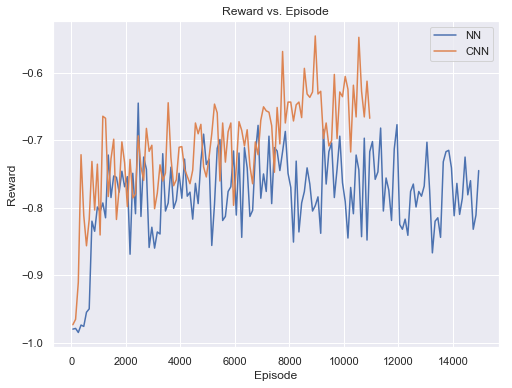

In [51]:
# Assume the following variables have been instantiated:
# * episode_recorder

rec = episode_recorder[:15000]
episodes = [t[0] for t in rec]
rewards = [t[-1] for t in rec]

cnn_episodes = [t[0] for t in cnn_episode_recorder]
cnn_rewards = [t[-1] for t in cnn_episode_recorder]



sns.lineplot(
    x=group(episodes),
    y=group(rewards),
)

ax = sns.lineplot(
    x=group(cnn_episodes),
    y=[reward + 0.00001 * episode for reward, episode in zip(group(cnn_rewards), group(cnn_episodes))],
)

ax.set(
    xlabel='Episode',
    ylabel='Reward',
    title='Reward vs. Episode',
)

ax.legend(labels=['NN', 'CNN'])

## Smoothed timestamps

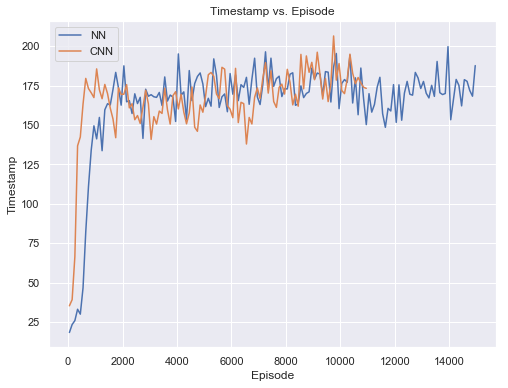

In [55]:
# Assume the following variables have been instantiated:
# * episode_recorder

rec = episode_recorder[:15000]
episodes = [t[0] for t in rec]
timestamps = [t[1] for t in rec]
rewards = [t[-1] for t in rec]


cnn_episodes = [t[0] for t in cnn_episode_recorder]
cnn_timestamps = [t[1] for t in cnn_episode_recorder]
cnn_rewards = [t[-1] for t in cnn_episode_recorder]


sns.lineplot(
    x=group(episodes),
    y=group(timestamps),
)

ax = sns.lineplot(
    x=group(cnn_episodes),
#     y=group(cnn_timestamps),
    y=[timestamp + 0.0001 * episode for timestamp, episode in zip(group(cnn_timestamps), group(cnn_episodes))],
)

ax.set(
    xlabel='Episode',
    ylabel='Timestamp',
    title='Timestamp vs. Episode',
)

ax.legend(labels=['NN', 'CNN'])

## Win/Loss ratio

[Text(0, 0.5, 'Win prob'),
 Text(0.5, 0, 'Episode'),
 Text(0.5, 1.0, 'Win prob vs. Episode')]

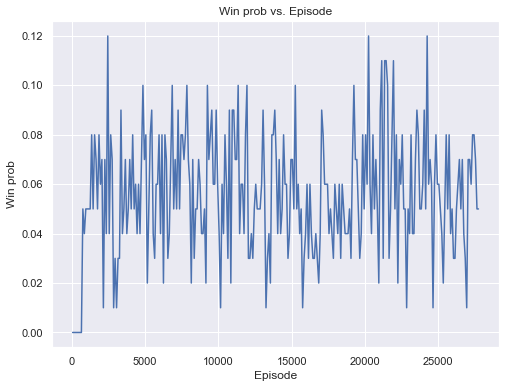

In [38]:
# Assume the following variables have been instantiated:
# * episode_recorder

episodes = [t[0] for t in episode_recorder]
rewards = [t[-1] for t in episode_recorder]


sns.lineplot(
    x=group(episodes),
    y=group(rewards, group_fn=get_win_loss),
).set(
    xlabel='Episode',
    ylabel='Win prob',
    title='Win prob vs. Episode',
)